In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/')

Mounted at /content/drive


In [2]:
import Data_generator_multiple as dg
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import math, random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import animation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed = 32
num_stocks = 2
npaths = 30000
seq_length = 240
T=10
s0=np.array([1,1])
mu = np.array([0.12, 0.12])
#mu = np.array([0.0362, 0.0036])
k = 0.075
#cov = np.array([[0.0225, 0.00132],[0.00132, 0.0016]])
cov = np.array([[0.4-k, k],[k, 0.4-k]])
trade_cost = [0.01,0.01]
utility_gamma = 2.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 70
learning_rate = 0.01

In [19]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed = 36
num_stocks = 3
npaths = 30000
seq_length = 240
T=10
s0=np.array([1,1,1])
mu = np.array([0.12, 0.12, 0.12])
cov = 0.0*np.ones([3,3])
np.fill_diagonal(cov,0.16)
trade_cost = [0.01,0.01,0.01]
utility_gamma = 2.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 60
learning_rate = 0.01

In [3]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed = 36
num_stocks = 10
npaths = 25000
seq_length = 240
T=10
s0=np.array([1,1,1,1,1,1,1,1,1,1])
mu = 0.12*s0
cov = 0.032*np.ones([num_stocks,num_stocks])
np.fill_diagonal(cov,0.16)
trade_cost = [0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
utility_gamma = 2.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 80
learning_rate = 0.001

In [4]:
# set up the trading costs
all_cost = np.ones([num_stocks,seq_length-1,npaths])
for i in range(num_stocks):
  all_cost[i,:,:] = trade_cost[i]

# calculate rho: Notice the single is used only for plotting a 2 asset situation
if (num_stocks==2):
    rho = np.round(cov[0,1]/(np.sqrt(cov[0,0]*cov[1,1])),3)

In [5]:
# To determine optimal trading frequency, based on Johannes Muhle-Karbe's paper, higher dimension waited to be verified
# step 1: Calculting the Markowitz optimal
Markowitz_opt = np.matmul(np.linalg.inv(cov),mu)/utility_gamma
Markowitz_opt_tensor =  torch.tensor(Markowitz_opt,dtype = torch.float).to(device)
# step 2: Define the distance for initial non trade region
delta = 0.1*np.power(np.diag(cov)*trade_cost/utility_gamma,1/3)
delta_tensor = torch.tensor(delta, dtype = torch.float).to(device)

In [6]:
# Create a stock simulation with prices, returns
stock = dg.ManyStocks(seed,num_stocks,mu,s0,cov,npaths,seq_length-1,T)
returns = torch.tensor(stock.Returns(),dtype=torch.float).to(device)
# Create a default strategy as initial input, better use the optimal strategy without cost
strategy = (torch.tensor(Markowitz_opt,dtype=torch.float).view(num_stocks,1,1)*torch.ones((num_stocks,seq_length,npaths),dtype=torch.float)).to(device)
# Create a trading cost
cost =  torch.tensor(all_cost,dtype=torch.double).to(device)

In [7]:
# Calculate return of specific strategy
def cal_return(strat):   
    r0 = torch.sum(strat[:,:-1, :]*returns,0)
    r1 = r0-torch.sum(cost*abs((r0+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r2 = r0-torch.sum(cost*abs((r1+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r3 = r0-torch.sum(cost*abs((r2+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r4 = r0-torch.sum(cost*abs((r3+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    #r5 = r0-torch.sum(cost*abs((r4+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    return r4

class Cal_return(nn.Module):
    def __init__(self):
        
        super().__init__()

    def forward(self, strat):

        return cal_return(strat) 

In [8]:
# Define a log utility function
class LogUtilityLoss(torch.nn.Module):
    
    def __init__(self):
        super(LogUtilityLoss,self).__init__()
        
    def forward(self,x):
        loss = -torch.mean(torch.log(x))
        return loss

# Define a power utility function
class PowerUtilityLoss(torch.nn.Module):
    
    def __init__(self,gamma):
        super(PowerUtilityLoss,self).__init__()
        self.gamma = gamma
        
    def forward(self,x):
        loss = -torch.mean((torch.pow(x,1-self.gamma)-1)/(1-self.gamma))
        return loss

In [9]:
# Customize a RNN layer with double relu for multiple assets
# considering returns data to build a changed strategy weight according to price change
class MyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, batch_size,dim_size):
        """Initialize params."""
        super(MyRNN, self).__init__()
        # read input parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dim_size = dim_size

        
        self.edge_coef = nn.Linear(dim_size,dim_size).to(device)

                
    # Forward function allows a form:
    # h_t = w_fc2*relu(w_fc1*relu(w_inp*x_t+b_inp+w_h*h_{t-1}+b_h)+b_fc1)+b_fc2+b_fc1-b_h1
    def forward(self, input, hidden):
      # create the pi_bar(merton optimal) and identity matrix
      pi_bar = (torch.tensor(Markowitz_opt,dtype=torch.float).view(self.dim_size,self.hidden_size,self.hidden_size)*\
                torch.ones((self.dim_size,self.hidden_size,npaths),dtype=torch.float)).to(device).squeeze(1)
      e_matrix = torch.eye(self.dim_size).to(device)
      
      def recurrence(input, hidden):
        #creating scalars, empty vectors and normalized v
        eps = 1e-5
        hidden = hidden.squeeze(1)
        hidden_temp = hidden
        judge_mat = torch.zeros([self.dim_size,self.batch_size],requires_grad=True).to(device)
        v = torch.nn.functional.normalize(self.edge_coef.weight, p=2.0, dim=1, eps=1e-12, out = None)
        
        # loop once to find the fitness of each asset
        for j in range(self.dim_size):
          # create v for each asset
          vj = torch.nn.functional.normalize(self.edge_coef.weight, p=2.0, dim=1, eps=1e-12, out = None)[j,:]
          # calculate lambda for all assets
          lambda_pi_plus = (torch.abs(self.edge_coef.bias[j])*torch.ones(self.batch_size).to(device) - torch.matmul(vj,hidden-pi_bar))/(torch.matmul(vj,e_matrix[j,:]))
          lambda_pi_minus = (-torch.abs(self.edge_coef.bias[j])*torch.ones(self.batch_size).to(device) - torch.matmul(vj,hidden-pi_bar))/(torch.matmul(vj,e_matrix[j,:]))
          hidden_new = hidden + (lambda_pi_plus.view(self.batch_size,1)*e_matrix[j,:]).T*(torch.matmul(vj,hidden-pi_bar)>torch.abs(self.edge_coef.bias[j]))+\
                  (lambda_pi_minus.view(self.batch_size,1)*e_matrix[j,:]).T*(torch.matmul(vj,hidden-pi_bar)<-torch.abs(self.edge_coef.bias[j]))
          # create a matrix recording the fitness of such asset
          judge = (torch.matmul(v,hidden_new-pi_bar)<torch.abs(self.edge_coef.bias.view(self.dim_size,1))+eps) & (torch.matmul(v,hidden_new-pi_bar)>-torch.abs(self.edge_coef.bias.view(self.dim_size,1))-eps)

          judge = torch.min(judge,0).values
          judge_mat[j,:] = judge
        # create a matrix recording the assets which project to notrade region with only one projection
        judge_mat = torch.max(judge_mat,0).values
        del hidden_new
        torch.cuda.empty_cache()

        for j in range(self.dim_size):
          # create v for each asset
          vj = torch.nn.functional.normalize(self.edge_coef.weight, p=2.0, dim=1, eps=1e-12, out = None)[j,:]
          # calculate lambda for all assets
          lambda_pi_plus = (torch.abs(self.edge_coef.bias[j])*torch.ones(self.batch_size).to(device) - torch.matmul(vj,hidden_temp-pi_bar))/(torch.matmul(vj,e_matrix[j,:]))
          lambda_pi_minus = (-torch.abs(self.edge_coef.bias[j])*torch.ones(self.batch_size).to(device) - torch.matmul(vj,hidden_temp-pi_bar))/(torch.matmul(vj,e_matrix[j,:]))
          # one step projection of each asset
          hidden_temp = hidden_temp + (lambda_pi_plus.view(self.batch_size,1)*e_matrix[j,:]).T*(torch.matmul(vj,hidden_temp-pi_bar)>torch.abs(self.edge_coef.bias[j]))+\
                  (lambda_pi_minus.view(self.batch_size,1)*e_matrix[j,:]).T*(torch.matmul(vj,hidden_temp-pi_bar)<-torch.abs(self.edge_coef.bias[j]))

        del lambda_pi_plus
        del lambda_pi_minus
        torch.cuda.empty_cache()  
        # start a bisection method to find the exact boundary of assets without one fitness projection
        h_in =  pi_bar
        h_out = (1-judge_mat)*hidden
        for i in range(8):
          h_m = h_in+(-h_in+h_out)/2
          judge = (torch.matmul(v,h_m-pi_bar)<=torch.abs(self.edge_coef.bias.view(self.dim_size,1))+eps) & (torch.matmul(v,h_m-pi_bar)>=-torch.abs(self.edge_coef.bias.view(self.dim_size,1))-eps)
          judge = torch.min(judge,0).values
          h_out = (~judge)*h_m+(judge)*h_out
          h_in = (judge)*h_m+(~judge)*h_in
        hidden = (judge_mat*hidden_temp+(1-judge_mat)*h_m).unsqueeze(1)
        return hidden


      output = []
      steps = range(input.size(1))
      #myret = returns
      for i in steps:
          if i ==0:
              hidden = input[:,0,:].view(self.dim_size,1,self.batch_size).to(device)
              #hidden = (torch.tensor(Markowitz_opt,dtype=torch.float).view(self.dim_size,1,1)*torch.ones((self.dim_size,1,self.batch_size),dtype=torch.float)).to(device)
          else:
              # pi_t = myrotate(pi_{t-1}*(1+r_t)/(1+sum(pi_{t-1}*r_t))) due to change of price after rebalance
              adjust_pi = hidden.view(self.dim_size,1,self.batch_size)*(1+returns[:,i-1,:].view(self.dim_size,1,self.batch_size))\
                                    /(1+torch.sum(hidden.view(self.dim_size,1,self.batch_size)*returns[:,i-1,:].view(self.dim_size,1,\
                                    self.batch_size),0))
                                    
                           

              hidden = recurrence(input[:,i,:].view(self.dim_size,self.input_size,self.batch_size), adjust_pi)
            
          output.append(hidden)

      output = torch.cat(output, 1)

      return output, hidden

In [10]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, batch_size, seq_length, dim_size):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.dim_size = dim_size
        # the rnn layer which works as out, hidden_t = f(out_(t), hidden_(t-1)), used to approximate pi^*_(t)= f(pi^*_(t-1),pi_t)
        self.rnn = MyRNN(input_size, hidden_size, batch_size, dim_size).to(device)
        self.out = nn.Linear(dim_size, hidden_size,bias=False).to(device)
        # initialize some bias and weight
        self.rnn.edge_coef.bias = torch.nn.Parameter(delta_tensor)
        self.rnn.edge_coef.weight = torch.nn.Parameter(torch.eye(self.dim_size).to(device))
        self.out.weight = torch.nn.Parameter(*torch.ones_like(self.out.weight))

    def step(self, input, hidden=None):
        output, hidden = self.rnn(input, hidden).to(device)
        output2 = self.out.weight.view(dim_size,hidden_size,hidden_size)*output
        return output, output2

    def forward(self, inputs, hidden=None):
        hidden = self.__init__hidden().to(device)
        output, hidden = self.rnn(inputs.float(), hidden.float())
        # output2 the overall wealth at time T
        output2 = torch.prod(cal_return(output).to(device)+1,0)
        return  output, output2
        #return  output
        
    def __init__hidden(self):
        hidden = strategy[:,0,:].to(device)
        return hidden

In [11]:
input_size = 1
hidden_size = 1
n_layers = 1
batch_size = npaths
seq_length = seq_length
dim_size = num_stocks

model = SimpleRNN(input_size, hidden_size, n_layers, batch_size, seq_length,dim_size).to(device)
#criterion = LogUtilityLoss()
criterion = PowerUtilityLoss(utility_gamma)
model.out.weight.requires_grad = False
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=1)



In [12]:
losses = np.zeros(n_epochs+1) 

for epoch in range(n_epochs+1):
    inputs = strategy.to(device)
    fina_strat, outputs = model(inputs.double(), None)

    loss = criterion(outputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

    losses[epoch] += loss
    if epoch % 10 == 0:
        print(epoch, loss)
        print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))


0 tensor(-0.5082, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-0 lr: 0.001
10 tensor(-0.5288, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-10 lr: 0.001
20 tensor(-0.5380, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-20 lr: 0.001
30 tensor(-0.5416, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-30 lr: 0.001
40 tensor(-0.5425, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-40 lr: 0.001
50 tensor(-0.5429, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-50 lr: 0.001
60 tensor(-0.5429, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-60 lr: 0.001
70 tensor(-0.5430, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-70 lr: 0.001
80 tensor(-0.5430, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-80 lr: 0.001


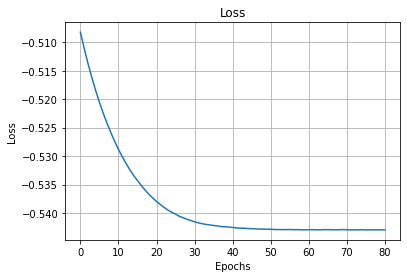

In [13]:
# Plot loss curve
epochs = range(n_epochs+1)

fig, ax = plt.subplots()
ax.plot(epochs, losses)

ax.set(xlabel='Epochs', ylabel='Loss',
       title='Loss')
ax.grid()
from google.colab import files
#fig.savefig("loss_correl{}_mu{}_sigma{}.png".format(rho,mu,np.diag(cov)), format='png', dpi=500)
#files.download("loss_correl{}_mu{}_sigma{}.png".format(rho,mu,np.diag(cov))) 

plt.show()


In [32]:
# output the weights and bias of the model parameter
for name, param in model.named_parameters():
     print (name, param.data)

rnn.edge_coef.weight tensor([[ 1.0906, -0.0413, -0.0050],
        [-0.0252,  1.0960, -0.0367],
        [ 0.0195, -0.0319,  1.1005]], device='cuda:0')
rnn.edge_coef.bias tensor([0.0843, 0.0831, 0.0734], device='cuda:0')
out.weight tensor([1., 1., 1.], device='cuda:0')


In [ ]:
# Plain plot of 2 chosen dimensions of assets
ex_strategy = torch.rand([num_stocks,seq_length,npaths]).to(device).view([num_stocks,seq_length,npaths])
o = model(ex_strategy)[0]
x = o.cpu().detach().numpy()[0,7,:].reshape([1,npaths])
y = o.cpu().detach().numpy()[1,7,:].reshape([1,npaths])
#z = o.cpu().detach().numpy()[2,7,:].reshape([1,npaths])
plt.figure(figsize=(6,5))
#plt.xlim((0.05,0.25))
#plt.ylim((0.05,0.25))
#plt.xticks(np.arange(0.05,0.25,0.05))
#plt.yticks(np.arange(0.05,0.25,0.05))
plt.grid()
plt.title(label='No trade Region')
plt.plot(x, y, 'o', color='blue')
plt.savefig("mu{}_sigmasquare{}.png".format(mu,np.diag(cov)), format='png', dpi=500)
files.download("mu{}_sigmasquare{}.png".format(mu,np.diag(cov)))
plt.show()

In [14]:
# Comparison between different ESR, notice this is specially defined for the liquid and illiquid case
# Calculate the simulated ESR
ESR_Simulation = torch.log(torch.pow(torch.mean(torch.pow(outputs,1-utility_gamma)),1/(1-utility_gamma)))/T
# Calculate the rho matrix
rho_matrix = cov/np.sqrt(np.diag(cov))/((np.sqrt(np.diag(cov))).T)
# Creating beta alpha and sigma_I
beta = np.zeros([num_stocks,num_stocks-1])
sigma_I = np.zeros([num_stocks,1])
lambda_I = np.zeros([num_stocks,1])
pi_bar = np.zeros([num_stocks,1])
reduction = np.zeros([num_stocks,1])
for s in range(num_stocks):
  rho_s = np.delete(rho_matrix,s,1)[s,:]
  sigma_temp = np.delete(np.delete(cov,s,0),s,1)
  vec_temp = np.delete(cov,s,0)[:,s]
  beta[s,:] = np.matmul(np.linalg.inv(sigma_temp),vec_temp)
  sigma_I[s] = cov[s,s]*(1-np.matmul(rho_s,rho_s.T))
  pi_bar[s] = (mu[s]-np.matmul(beta[s,:],np.delete(mu,s,0).T))/(sigma_I[s]*utility_gamma)
  lambda_I[s] = np.power((0.75*utility_gamma*utility_gamma*pi_bar[s]*pi_bar[s]*sigma_I[s]*sigma_I[s]*\
                 (np.matmul(np.matmul((vec_temp-np.delete(mu,s,0)).T,np.linalg.inv(sigma_temp)),(vec_temp-np.delete(mu,s,0)))+(1-pi_bar[s])*(1-pi_bar[s])*sigma_I[s]))*trade_cost[s],1/3)
  reduction[s] = np.power(lambda_I[s],2)/(2*sigma_I[s]*utility_gamma)
ESR_Theo_max = np.matmul(np.matmul(mu.T,np.linalg.inv(cov)),mu)/2/utility_gamma-np.max(reduction)
ESR_Theo_min = np.matmul(np.matmul(mu.T,np.linalg.inv(cov)),mu)/2/utility_gamma-np.sum(reduction)
print(ESR_Simulation)
print(ESR_Theo_max)
print(ESR_Theo_min)

tensor(0.0783, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
0.07991749239459517
0.07596063823166631


In [ ]:
# Plot of rotating gif figure of 3-d assets
ex_strategy = torch.rand([num_stocks,seq_length,npaths]).to(device).view([num_stocks,seq_length,npaths])
o = model(ex_strategy)[0]
fig = plt.figure()
ax = Axes3D(fig)
x = o.cpu().detach().numpy()[0,10,:].reshape([1,npaths])
y = o.cpu().detach().numpy()[1,10,:].reshape([1,npaths])
z = o.cpu().detach().numpy()[2,10,:].reshape([1,npaths])

#ax.scatter(x, y, z, marker='.',color='blue');
def init():
    ax.scatter(x, y, z, marker='.', s=20, c="blue", alpha=0.6)
    return fig,

def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=180, interval=20, blit=True,repeat = True)


writer = animation.PillowWriter(fps=15,metadata=dict(artist='Me'),bitrate=900)
anim.save('scatter.gif', writer=writer)
files.download('scatter.gif');